## Acoustic Scattering Produced by a Circular Obstacle in an Infinite Domain

In [2]:
%load_ext autoreload
%autoreload 2
#--------------------------------------------------------------
# Import Libraries
import numpy as np
import pandas as pd
#--------------------------------------------------------------
# Import Functions
from scat_circ import sound_hard_circle_calc 
from scat_circ import mask_displacement
from scat_circ import plot_exact_displacement
from scat_circ import plot_mesh_from_file
from scat_circ import measure_execution_time
from scat_circ import extract_fem_displacements
from scat_circ import plot_fem_displacements
from scat_circ import plot_pinns_displacements
from scat_circ import calculate_relative_errors
from pinns_scat_circ import generate_points
from pinns_scat_circ import plot_points
from pinns_scat_circ import initialize_and_load_model
from pinns_scat_circ import predict_displacement_pinns 
from pinns_scat_circ import process_displacement_pinns
from pinns_scat_circ import measure_model_time_pinns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameters of the model

In [3]:
r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]

### Analytical Solution

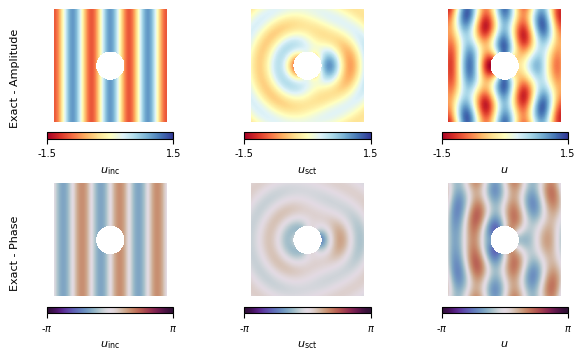

In [4]:
import matplotlib.pyplot as plt

# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Plot the displacement amplitude
plot_exact_displacement(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

### Finite Element Method (FEM)

#### Mesh

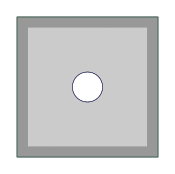

In [5]:
# plot the mesh from the file for illustration with reduced number of points
file_path_msh = "AcousticScattering/scattering.msh"
plot_mesh_from_file(file_path_msh)

#### FEM solution

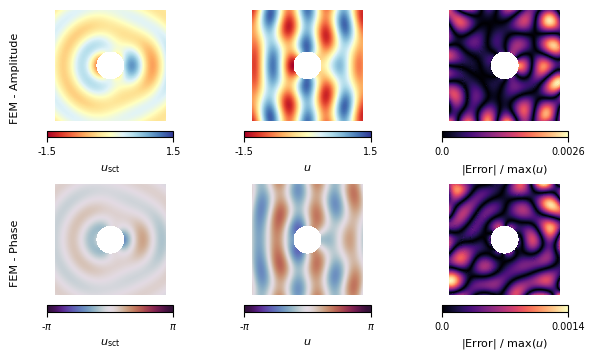

In [6]:
# data u_scn
file_path_u_scn = "AcousticScattering/u.pos"
uscn_amp_interp_fem, uscn_phase_interp_fem, u_amp_fem, u_phase_fem, \
diff_uscn_amp_fem, diff_u_amp_fem, diff_u_scn_phase_fem, diff_u_phase_fem = \
extract_fem_displacements(file_path_u_scn, r_i, l_se, k, n_grid, u_scn_exact, u_exact)
plot_fem_displacements(X, Y, uscn_amp_interp_fem, u_amp_fem, diff_u_amp_fem, uscn_phase_interp_fem, u_phase_fem, diff_u_scn_phase_fem)

#### Accuracy

In [29]:
# Calculate and print the relative errors
rel_error_uscn_amp_fem, rel_error_uscn_phase_fem, max_diff_uscn_amp_fem, min_diff_uscn_amp_fem, max_diff_u_phase_fem, min_diff_u_phase_fem = calculate_relative_errors(u_scn_exact, u_exact, diff_uscn_amp_fem, diff_u_scn_phase_fem, R_exact, r_i)
mean_rel_error_fem = (rel_error_uscn_amp_fem + rel_error_uscn_phase_fem) / 2
print(f"Relative error in the scattered field (u_scn) amplitude: {mean_rel_error_fem:.2e}")
print(f"Relative error in the he scattered field (u_scn) phase: {rel_error_uscn_phase_fem:.2e}")
print(f"Max diff in the scattered field (u_scn) amplitude: {max_diff_uscn_amp_fem:.2e}")
print(f"Min diff in the scattered field (u_scn) amplitude: {min_diff_uscn_amp_fem:.2e}")
print(f"Max diff in the scattered field (u_scn) phase: {max_diff_u_phase_fem:.2e}")
print(f"Min diff in the scattered field (u_scn) phase: {min_diff_u_phase_fem:.2e}")


Relative error in the scattered field (u_scn) amplitude: 3.35e-03
Relative error in the he scattered field (u_scn) phase: 2.28e-03
Max diff in the scattered field (u_scn) amplitude: 3.68e-03
Min diff in the scattered field (u_scn) amplitude: -3.85e-03
Max diff in the scattered field (u_scn) phase: 2.35e-03
Min diff in the scattered field (u_scn) phase: -2.50e-03


#### Computation time

In [37]:
# Define the path to the getdp executable (this can be changed per machine)
getdp_path = "/home/orincon/onelab-Linux64/getdp"

# Define the rest of the command arguments to solve the model using getdp
command_args = "AcousticScattering/scattering.pro -solve Scattering -pos Wave -v2"

# Number of runs to measure statistically
num_runs = 100  # You can change this based on how many runs you want

# Example usage
average_time_fem, std_dev_time_fem, min_time_fem, max_time_fem = measure_execution_time(getdp_path, command_args, num_runs)
print(f"Statistical Measurement of Execution Time (over {num_runs} runs):")
print(f"Average Time: {average_time_fem} seconds ± {std_dev_time_fem} seconds")
print(f"Minimum Time: {min_time_fem} seconds")
print(f"Maximum Time: {max_time_fem} seconds")

Statistical Measurement of Execution Time (over 100 runs):
Average Time: 3.257 seconds ± 0.776 seconds
Minimum Time: 2.41 seconds
Maximum Time: 7.457 seconds


### Physics informed neural networks (PINNs)

#### Collocation points

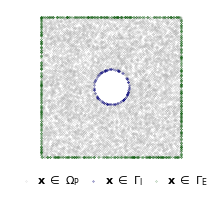

In [13]:
# Parameters
n_Omega_P = 10_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 250          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
l_e = np.pi              # Length of the semi-edge of the square
k = 3.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * l_e    # Side length of the square

# Generate points
x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top = generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E)
plot_points(x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)

#### Physics informed neural networks (PINNs) solution

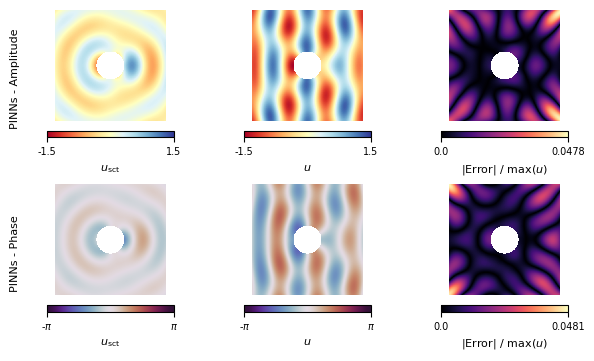

In [29]:
# Initialize and load the model
model_path = 'Scattering.pt'
model = initialize_and_load_model(model_path)

# Predict the displacement
u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_e, r_i, k, n_grid)

# Example usage
u_sc_amp_pinns,u_sc_phase_pinns,u_amp_pinns, u_phase_pinns, diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
    model, l_e, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
)

plot_pinns_displacements(X, Y, u_sc_amp_pinns, u_amp_pinns, diff_uscn_amp_pinns, u_sc_phase_pinns, u_phase_pinns, diff_u_scn_phase_pinns)

#### Accuracy

In [53]:
# Calculate and print the relative errors
rel_error_uscn_amp_pinns, rel_error_uscn_phase_pinns, max_diff_uscn_amp_pinns, min_diff_uscn_amp_pinns, max_diff_u_phase_pinns, min_diff_u_phase_pinns = calculate_relative_errors(u_scn_exact, u_exact, diff_uscn_amp_pinns, diff_u_scn_phase_pinns, R_exact, r_i)
mean_rel_error_pinns = (rel_error_uscn_amp_pinns + rel_error_uscn_phase_pinns) / 2
print(f"Relative error in the u_scn phase: {rel_error_uscn_phase_pinns:.2e}")
print(f"Max diff in the u_scn amp: {max_diff_uscn_amp_pinns:.2e}")
print(f"Min diff in the u_scn amp: {min_diff_uscn_amp_pinns:.2e}")
print(f"Max diff in the u_scn phase: {max_diff_u_phase_pinns:.2e}")
print(f"Min diff in the u_scn phase: {min_diff_u_phase_pinns:.2e}")

Relative error in the u_scn phase: 7.62e-02
Max diff in the u_scn amp: 7.06e-02
Min diff in the u_scn amp: -4.27e-02
Max diff in the u_scn phase: 4.88e-02
Min diff in the u_scn phase: -8.29e-02


#### Computation time

In [55]:
num_runs = 1000
average_time_pinns, std_dev_time_pinns, min_time_pinns, max_time_pinns = measure_model_time_pinns(model, l_se, r_i, k, n_grid, num_runs)
print(f"Average Time: {average_time_pinns} seconds ± {std_dev_time_pinns} seconds")
print(f"Standard Deviation: {std_dev_time_pinns:.3f} seconds")
print(f"Minimum Time: {min_time_pinns:.3f} seconds")
print(f"Maximum Time: {max_time_pinns:.3f} seconds")

Average Time: 0.012 seconds ± 0.004 seconds
Standard Deviation: 0.004 seconds
Minimum Time: 0.009 seconds
Maximum Time: 0.116 seconds


Statistical Measurement of Execution Time (over 100 runs):
Average Time: 0.059 seconds
Standard Deviation: 0.023 seconds
Minimum Time: 0.041 seconds
Maximum Time: 0.282 seconds

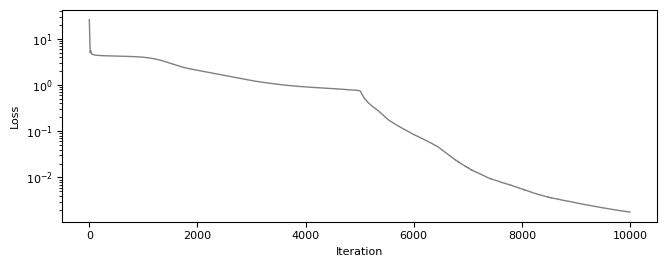

In [84]:
data_loss = pd.read_csv('datos/scattering_training_loss.csv')
plt.figure(figsize=(6.5, 2.5))
plt.semilogy(data_loss['Iter'], data_loss['Loss'], label='Loss', color='gray', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('figs/loss.svg', dpi=300, bbox_inches='tight')

In [89]:
import os
import imageio
import matplotlib.pyplot as plt
from PIL import Image

# Directorio de imágenes
image_dir = 'figures_iters/'
gif_filename = 'figs/scattering.gif'

# Inicializar el modelo (esto se asume que ya lo estás haciendo correctamente)
limit = 10_001
step = 500

# Crear las imágenes
for i in range(step, limit, step):
    model_path = f'models_iters/scattering_{i}.pt'
    model = initialize_and_load_model(model_path)

    # Predecir el desplazamiento (esto también ya se asume que funciona)
    u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns = predict_displacement_pinns(model, l_e, r_i, k, n_grid)

    u_sc_amp_pinns, u_sc_phase_pinns, u_amp_pinns, u_phase_pinns, diff_uscn_amp_pinns, diff_u_scn_phase_pinns = process_displacement_pinns(
        model, l_e, r_i, k, n_grid, X, Y, R_exact, u_scn_exact
    )

    # Crear la figura y los ejes
    fig, axs = plt.subplots(ncols=3, figsize=(6.5, 2.5))

    # Primera gráfica
    c1 = axs[0].pcolormesh(X, Y, u_sc_amp_pinns, cmap="RdYlBu", vmin=-1.5, vmax=1.5, rasterized=True)
    cb1 = fig.colorbar(c1, ax=axs[0], shrink=0.8, orientation="horizontal", pad=0.07, format='%.1f')
    cb1.set_label(r"$u_{\rm{sct}}$ - PINNs")
    cb1.set_ticks([-1.5, 1.5])
    axs[0].axis("off")
    axs[0].set_aspect("equal")

    # Segunda gráfica
    c2 = axs[1].pcolormesh(X, Y, np.real(u_scn_exact), cmap="RdYlBu", vmin=-1.5, vmax=1.5, rasterized=True)
    cb2 = fig.colorbar(c2, ax=axs[1], shrink=0.8, orientation="horizontal", pad=0.07, format='%.1f')
    cb2.set_label(r"$u_{\rm{sct}}$ - Exact")
    cb2.set_ticks([-1.5, 1.5])
    axs[1].axis("off")
    axs[1].set_aspect("equal")

    # Tercera gráfica
    diff = u_amp_pinns - np.real(u_scn_exact)
    c3 = axs[2].pcolormesh(X, Y, np.abs(np.real(u_scn_exact) - u_sc_amp_pinns) / np.abs(u_sc_amp_pinns).max(), cmap="magma", vmin=0, vmax=1, rasterized=True)
    cb3 = fig.colorbar(c3, ax=axs[2], shrink=0.8, orientation="horizontal", pad=0.07, format='%.1f')
    cb3.set_label(r"|Error| / max($u_{\rm{sct}}$)")
    cb3.set_ticks([0, 1])
    axs[2].axis("off")
    axs[2].set_aspect("equal")
    fig.text(-0.01, 0.60, r'Amplitude', fontsize=8, fontweight='regular', va='center', ha='center', rotation='vertical')

    # Ajustar el espacio entre las gráficas
    plt.tight_layout()
    image_path = os.path.join(image_dir, f'scattering_{i}.png')
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# Crear el GIF
images = []

for i in range(step, limit, step):
    image_path = os.path.join(image_dir, f'scattering_{i}.png')
    
    # Leer la imagen usando PIL para conservar los niveles de color
    img = Image.open(image_path)
    
    # Convertir la imagen a RGB para evitar problemas de paleta de colores (GIFs limitados)
    img_rgb = img.convert("RGB")
    
    # Añadir la imagen al listado
    images.append(img_rgb)

# Guardar el GIF con la frecuencia de fotogramas deseada
imageio.mimsave(gif_filename, images, fps=3)
 

### Comparative

In [57]:
import pandas as pd
import numpy as np

# Crear un diccionario con los resultados de los tiempos
resultados_tiempos = {
    'Método': ['FEM', 'PINNs', 'FEM/PINNs', 'PINNs/FEM'],
    'Tiempo Promedio (s)': [average_time_fem, average_time_pinns, average_time_fem / average_time_pinns, average_time_pinns / average_time_fem],
    'Desviación Estándar (s)': [
        std_dev_time_fem,
        std_dev_time_pinns,
        np.sqrt((std_dev_time_fem / average_time_fem)**2 + (std_dev_time_pinns / average_time_pinns)**2),
        np.sqrt((std_dev_time_pinns / average_time_pinns)**2 + (std_dev_time_fem / average_time_fem)**2)
    ],
    'Tiempo Máximo (s)': [max_time_fem, max_time_pinns, max_time_fem / max_time_pinns, max_time_pinns / max_time_fem],
    'Tiempo Mínimo (s)': [min_time_fem, min_time_pinns, min_time_fem / min_time_pinns, min_time_pinns / min_time_fem]
}

# Crear un DataFrame de pandas para los tiempos
df_resultados_tiempos = pd.DataFrame(resultados_tiempos)

# Guardar el DataFrame en un archivo CSV con tres decimales
df_resultados_tiempos.to_csv('datos/EvaluationTimes.csv', index=False, float_format='%.3f')

# Crear un diccionario con los resultados de errores relativos
resultados_errores = {
    'Método': ['FEM', 'PINNs', 'FEM/PINNs', 'PINNs/FEM'],
    'Error Relativo u_scn': [
        mean_rel_error_fem, 
        mean_rel_error_pinns, 
        mean_rel_error_fem / mean_rel_error_pinns, 
        mean_rel_error_pinns / mean_rel_error_fem
    ],
    'Max Diff u_scn (Amp)': [
        max_diff_uscn_amp_fem, 
        max_diff_uscn_amp_pinns, 
        max_diff_uscn_amp_fem / max_diff_uscn_amp_pinns, 
        max_diff_uscn_amp_pinns / max_diff_uscn_amp_fem
    ],
    'Min Diff u_scn (Amp)': [
        min_diff_uscn_amp_fem, 
        min_diff_uscn_amp_pinns, 
        min_diff_uscn_amp_fem / min_diff_uscn_amp_pinns, 
        min_diff_uscn_amp_pinns / min_diff_uscn_amp_fem
    ],
    'Max Diff u_scn (Phase)': [
        max_diff_u_phase_fem, 
        max_diff_u_phase_pinns, 
        max_diff_u_phase_fem / max_diff_u_phase_pinns, 
        max_diff_u_phase_pinns / max_diff_u_phase_fem
    ],
    'Min Diff u_scn (Phase)': [
        min_diff_u_phase_fem, 
        min_diff_u_phase_pinns, 
        min_diff_u_phase_fem / min_diff_u_phase_pinns, 
        min_diff_u_phase_pinns / min_diff_u_phase_fem
    ]
}

# Crear un DataFrame de pandas para los errores
df_errores = pd.DataFrame(resultados_errores)

# Guardar el DataFrame en un archivo CSV con notación científica
df_errores.to_csv('datos/Accuracy.csv', index=False, float_format='%.2e')

# Imprimir los DataFrames para ver los resultados
df_resultados_tiempos


,Método,Tiempo Promedio (s),Desviación Estándar (s),Tiempo Máximo (s),Tiempo Mínimo (s)
0,FEM,3.257000,0.776000,7.457000,2.410000
1,PINNs,0.012000,0.004000,0.116000,0.009000
2,FEM/PINNs,271.416667,0.409728,64.284483,267.777778
3,PINNs/FEM,0.003684,0.409728,0.015556,0.003734


In [45]:
df_errores

,Método,Error Relativo u_scn,Max Diff u_scn (Amp),Min Diff u_scn (Amp),Max Diff u_scn (Phase),Min Diff u_scn (Phase)
0,FEM,0.003351,0.003677,-0.003847,0.002349,-0.002499
1,PINNs,0.074814,0.070623,-0.042722,0.048821,-0.082944
2,FEM/PINNs,0.044787,0.052066,0.090037,0.048106,0.030128
3,PINNs/FEM,22.327664,19.206482,11.106561,20.787464,33.191883
